# Model Evaluation - Multilabel

This notebook is designed to walk through different methods of modeling and evaluation for multilabel classification problems - i.e where samples may be positive for one or more traits. 

In [204]:
import pandas as pd
import numpy as np
import boto3
import s3fs
import os
import sys
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, hamming_loss
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
import warnings
import itertools
from scipy import stats
from matplotlib import pyplot as plt
plt.style.use('ggplot')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from Evaluator import Evaluator

In [205]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

In [206]:
filepath = "s3://voightlab-data/multilabel/Weighted/FeatureSelected/chi2/"

X_train = pd.read_csv(filepath + "X_train.csv", index_col=0)
y_train = pd.read_csv(filepath + "y_train.csv", index_col=0)
X_test = pd.read_csv(filepath + "X_test.csv", index_col=0)
y_test = pd.read_csv(filepath + "y_test.csv", index_col=0)

We do this next step if we plan on performing binary instead of multilabel classification. However we will still incorporate information about the other traits as features, appending the non-target traits to the feature vector for each sample. 

In [207]:
df_train = pd.concat([X_train, y_train], axis=1).reset_index()
df_test = pd.concat([X_test, y_test], axis=1).reset_index()

df_train.dropna(how='any', inplace=True)
df_test.dropna(how='any', inplace=True)

In [208]:
df_train.head()

,index,E034-H3K9me3.gappedPeak,E002-H3K36me3.gappedPeak,E063-H3K9me3.gappedPeak,E100-H3K36me3.gappedPeak,E068-H3K9me3.gappedPeak,E048-H3K9me3.gappedPeak,E108-H3K9me3.gappedPeak,E100-H3K9me3.gappedPeak,E115-H3K9me3.gappedPeak,...,E058-H3K9me3.gappedPeak,E040-H3K9me3.gappedPeak,E011-H3K4me3.gappedPeak,E028-H3K9me3.gappedPeak,E062-H3K9me3.gappedPeak,E061-H3K9me3.gappedPeak,is_BMI,is_CAD,is_T2D,is_lipids
0,3761,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1,0,0,0
1,2367,0.000000,0.156107,0.00000,0.142242,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,0,0
2,4085,0.000000,0.156107,0.00000,0.142242,0.097012,0.000000,0.00000,0.000000,0.093946,...,0.000000,0.000000,0.109313,0.00000,0.000000,0.091449,0,0,1,0
3,10218,0.000000,0.156107,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.109313,0.00000,0.000000,0.000000,0,0,0,0
4,7143,0.100616,0.156107,0.09914,0.000000,0.097012,0.039271,0.05685,0.078831,0.093946,...,0.115397,0.083985,0.109313,0.09549,0.077069,0.091449,0,0,0,0


In [209]:
# Specify which columns are target variables
labels = ['is_T2D', 'is_lipids', 'is_BMI', 'is_CAD']

X_train = df_train.drop(labels, axis=1)
y_train = df_train[labels]

X_test = df_test.drop(labels, axis=1)
y_test = df_test[labels]

for label in labels:
    assert label in y_train.columns
    assert label in y_test.columns

Lets get an idea of the breakdown of samples between different traits

In [210]:
print ("{} total training samples".format(len(y_train)))
print ("{} total testing samples".format(len(y_test)))
print ()

for col in y_train.columns:
    print ("Positive training samples for {}: {}".format(col, y_train[col].value_counts()[1]))
    print ("Positive testing samples for {}: {}".format(col, y_test[col].value_counts()[1]))
    print ()

5032 total training samples
1642 total testing samples

Positive training samples for is_T2D: 485
Positive testing samples for is_T2D: 143

Positive training samples for is_lipids: 571
Positive testing samples for is_lipids: 205

Positive training samples for is_BMI: 1015
Positive testing samples for is_BMI: 338

Positive training samples for is_CAD: 313
Positive testing samples for is_CAD: 104



In [211]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [212]:
y_train.head()

,is_T2D,is_lipids,is_BMI,is_CAD
0,0,0,1,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,0,0,0


In [213]:
'''
For multilabel problems, using subset accuracy can be a harsh metric since it requires an exact match
between the label vectors. The hamming score gives credit for partially matchin label vectors, i.e if the
model predicts some but not all of the labels correctly. 
'''
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    acc_list = []
    
    for index, value in enumerate(y_true):
        # Return indices where the label == 1
        set_true = set( np.where(y_true[index])[0] )
        
        set_pred = set( np.where(y_pred[index])[0] )
        row_acc = None
        
        # Hamming score equation for a given sample
        if len(set_true) == 0 and len(set_pred) == 0:
            row_acc = 1
        else:
            row_acc = len(set_true.intersection(set_pred)) / float(len(set_true.union(set_pred)))
        acc_list.append(row_acc)
        
    return np.mean(acc_list)

In [215]:
def feat_importance(scores, names, n=10, one_dim=True):
    imp = scores
    if not one_dim:
        imp,names = zip(*sorted(zip(imp[0],names)))
    else:
        imp,names = zip(*sorted(zip(imp,names)))
    
    return names[-n:]

In [216]:
def feat_overlap(labels, important_feats):
    for index, label in enumerate(labels):
        i = index
    
        while i < len(labels) - 1:
            intersect = set(important_feats[label]).intersection(set(important_feats[labels[i+1]]))
            print ("Intersect between {} and {} is {}".format(label, labels[i+1], len(intersect)))
            print ("Intersect is {}".format(intersect))
            print ()
            i+= 1

In [217]:
def get_sample_weights(y, weight):
    sample_weights = y.apply(lambda x: weight if x !=0 else 1.0)
    return sample_weights

In [218]:
def threshold(predictions, threshold, softmax=True):
    all_preds = []
    
    for row in predictions:
        if softmax:
            preds = [1 if pred > threshold else 0 for pred in row]
        else:
            preds = [1 if pred[1] > threshold else 0 for pred in row]
        all_preds.append(preds)
    
    return np.asarray(all_preds)

# Modeling Approaches

## 1. Training one model per class
Simplest method, here we're going to train one classifier per label, using that label as the positive class and all other labels as the negative class. Then we're going to evaluate model performance by class for accuracy, recalla and precision. We'll also take a look at the features selected as most important by each model to see how much overlap there is between classes. 

### RandomForest

In [219]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1,bootstrap=True, oob_score=True)

# Parameter grid for grid search
rf_params = {'n_estimators': stats.randint.rvs(100, 500, size=5),
			 'max_depth': stats.randint.rvs(2, len(X_train.columns) - 2, size=5), 
             'min_samples_leaf': [0.01, 0.05, 0.2],
             'class_weight':['balanced_subsample']}

cv = StratifiedShuffleSplit(n_splits=7, test_size=0.3)

# Grid search to iteratively search parameter space
rf_grid = RandomizedSearchCV(rf_model, n_iter=50, param_distributions=rf_params, cv=cv)

Trait: is_T2D

Model Performance:
 Precision: 0.12173913043478261
 Recall: 0.2937062937062937
 Accuracy: 0.7539585870889159



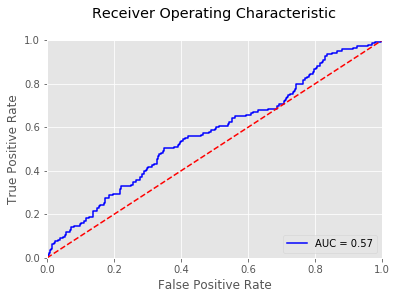

Trait: is_lipids

Model Performance:
 Precision: 0.19543147208121828
 Recall: 0.375609756097561
 Accuracy: 0.7289890377588307



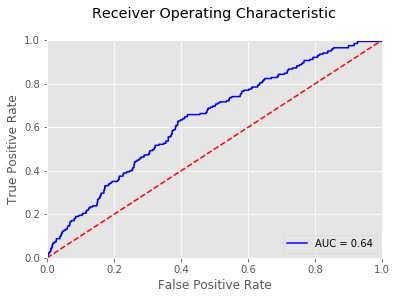

Trait: is_BMI

Model Performance:
 Precision: 0.2821869488536155
 Recall: 0.47337278106508873
 Accuracy: 0.643727161997564



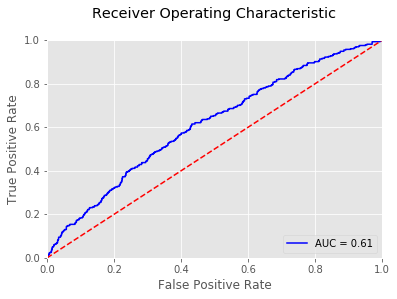

Trait: is_CAD

Model Performance:
 Precision: 0.08734939759036145
 Recall: 0.27884615384615385
 Accuracy: 0.7697929354445798



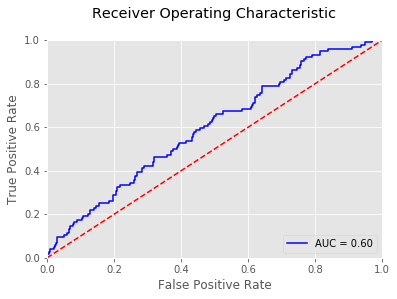

In [223]:
# After we've run grid search to figure out what params to use
et_model = ExtraTreesClassifier(n_estimators=300, max_depth=5, class_weight='balanced_subsample',  n_jobs=-1,bootstrap=True, oob_score=True)

# Save the top n important features from each model
important_feats = {}
top_n = 20

for label in y_train.columns:
    ovr_ytrain = y_train[label]
    ovr_ytest = y_test[label]
    
    sample_weights = get_sample_weights(ovr_ytrain, 2.0)
    et_model.fit(X_train, ovr_ytrain)
    
    imps = et_model.feature_importances_
    important_feats[label] = feat_importance(imps, X_train.columns, n=top_n)
    
    print ("Trait: {}\n".format(label))
    X_test.fillna(X_train.mean(), inplace=True)
    ev.summarize_performance(et_model, X_test, ovr_ytest)
    
    print ()
    ev.plot_roc_curve(et_model, X_test, ovr_ytest)
    
    

In [224]:
for index, label in enumerate(labels):
    i = index
    
    while i < len(labels) - 1:
        intersect = set(important_feats[label]).intersection(set(important_feats[labels[i+1]]))
        print ("Intersect between {} and {} is {}".format(label, labels[i+1], len(intersect)))
        i+= 1


Intersect between is_T2D and is_lipids is 6
Intersect between is_T2D and is_BMI is 6
Intersect between is_T2D and is_CAD is 3
Intersect between is_lipids and is_BMI is 3
Intersect between is_lipids and is_CAD is 9
Intersect between is_BMI and is_CAD is 3


### Logistic Regression

In [17]:
# L1 penalty means we are essentially using a lasso regression model here
log_model = LogisticRegression(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 max_iter=1000,
                                 n_jobs=-1)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Trait: is_BMI

Model Performance:
 Precision: 0.32006125574272587
 Recall: 0.5837988826815642
 Accuracy: 0.6463923673225999



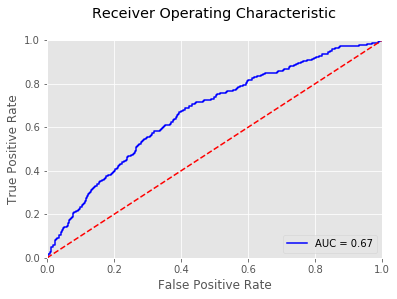

Trait: is_CAD

Model Performance:
 Precision: 0.08616187989556136
 Recall: 0.3173076923076923
 Accuracy: 0.7489564698867024



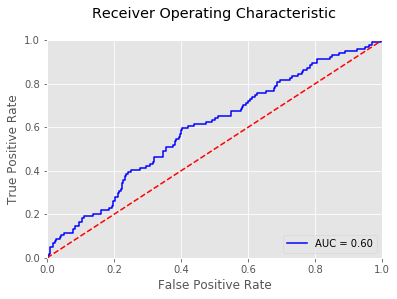

Trait: is_T2D

Model Performance:
 Precision: 0.09698275862068965
 Recall: 0.3082191780821918
 Accuracy: 0.689922480620155



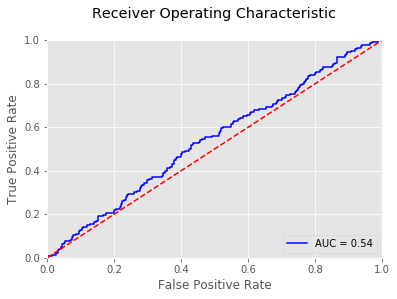

Trait: is_lipids

Model Performance:
 Precision: 0.15485074626865672
 Recall: 0.46111111111111114
 Accuracy: 0.6720333929636255



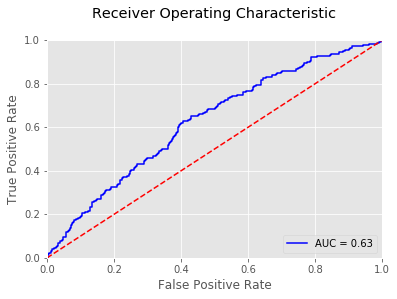

In [18]:
# Save the top n important features from each model
important_feats = {}
top_n = 200

for label in y_train.columns:
    ovr_ytrain = y_train[label]
    ovr_ytest = y_test[label]
    
    sample_weights = get_sample_weights(ovr_ytrain, 1.0)
    log_model.fit(X_train, ovr_ytrain, sample_weight=sample_weights)
    
    imps = et_model.feature_importances_
    important_feats[label] = feat_importance(imps, X_train.columns, n=top_n)
    
    print ("Trait: {}\n".format(label))
    ev.summarize_performance(log_model, X_test, ovr_ytest)
    print ()
    ev.plot_roc_curve(log_model, X_test, ovr_ytest)
    

In [19]:
for index, label in enumerate(labels):
    i = index
    
    while i < len(labels) - 1:
        intersect = set(important_feats[label]).intersection(set(important_feats[labels[i+1]]))
        print ("Intersect between {} and {} is {}".format(label, labels[i+1], len(intersect)))
        i+= 1

Intersect between is_T2D and is_lipids is 200
Intersect between is_T2D and is_BMI is 200
Intersect between is_T2D and is_CAD is 200
Intersect between is_lipids and is_BMI is 200
Intersect between is_lipids and is_CAD is 200
Intersect between is_BMI and is_CAD is 200


### Boosted Classifier

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=500,
                                      subsample = 0.7, 
                                      min_samples_leaf=0.1)

In [ ]:
# Save the top n important features from each model
important_feats = {}
top_n = 200

for label in y_train.columns:
    ovr_ytrain = y_train[label]
    ovr_ytest = y_test[label]
    
    sample_weights = get_sample_weights(ovr_ytrain, 3.0)
    gb_model.fit(X_train, ovr_ytrain, sample_weight=sample_weights)
    
    imps = gb_model.feature_importances_
    important_feats[label] = feat_importance(imps, X_train.columns, n=top_n)
    
    print ("Trait: {}\n".format(label))
    ev.summarize_performance(gb_model, X_test, ovr_ytest)
    print ()
    ev.plot_roc_curve(gb_model, X_test, ovr_ytest)

In [ ]:
for index, label in enumerate(labels):
    i = index
    
    while i < len(labels) - 1:
        intersect = set(important_feats[label]).intersection(set(important_feats[labels[i+1]]))
        print ("Intersect between {} and {} is {}".format(label, labels[i+1], len(intersect)))
        i+= 1

## 2. Multilabel Modeling

Here we will use models capable of handling labels in multilabel format directly. Model evaluation for precision and recall is performed by the evaluator class, which averages recall and precision across classes. An issue we have with estimating multilabel sets directly is that it is difficult to compare metrics directly to one vs rest classification methods. Additionally, we can only plot ROC curves by individual class. 

### Ridge Regression Classifier

In [22]:
rn_model = RadiusNeighborsClassifier(radius=5.0, p=1, metric='hamming')

In [23]:
rn_model.fit(X_train, y_train)

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='hamming',
             metric_params=None, outlier_label=None, p=1, radius=5.0,
             weights='uniform')

Model Performance:
 Precision: 0.0
 Recall: 0.0
 Accuracy: 0.6285032796660703


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


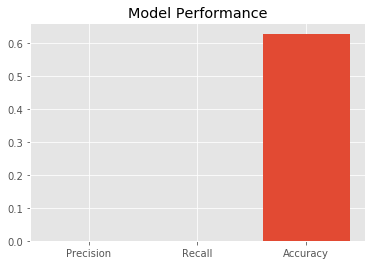

In [24]:
# Use 'average' argument to calculate precision and recall across classes
rn_metrics = ev.summarize_performance(rn_model, X_test, y_test,
                                       average='micro', 
                                       proba=True, 
                                       return_stats=True)

In [ ]:
predictions = threshold(rn_model.predict_proba(X_test), 0.25)

In [ ]:
y = ev.multilabel_recall(y_test, predictions)
plt.bar(y_train.columns, y)
plt.title("Recall")
plt.show()

In [ ]:
y = ev.multilabel_precision(y_test, predictions)
plt.bar(y_train.columns, y)
plt.title('Precision')
plt.show()

In [ ]:
print("Hamming score is {0:.2f}".format(hamming_score(y_test, predictions)))
print("Hamming loss is {0:.2f}".format(hamming_loss(y_test, predictions)))

### Random Forest 

In [82]:
rf_model = RandomForestClassifier(n_estimators=300,
                                  max_depth=15, 
                                  class_weight='balanced_subsample', 
                                  n_jobs=-1,
                                  bootstrap=True,
                                  oob_score=True)

In [83]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

Model Performance:
 Precision: 0.118508655126498
 Recall: 0.22588832487309646
 Accuracy: 0.4388789505068575


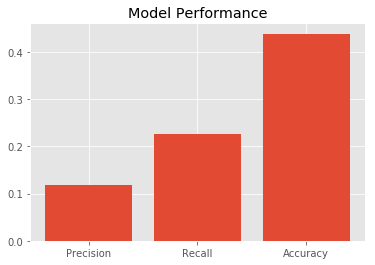

In [84]:
# Use 'average' argument to calculate precision and recall across classes
rf_metrics = ev.summarize_performance(rf_model, X_test, y_test,
                                       average='micro', 
                                       proba=True, 
                                       return_stats=True)

In [85]:
predictions = rf_model.predict(X_test)

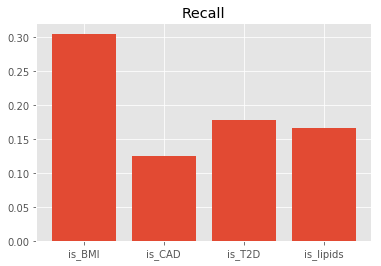

In [86]:
y = ev.multilabel_recall(y_test, predictions)
plt.bar(y_train.columns, y)
plt.title("Recall")
plt.show()

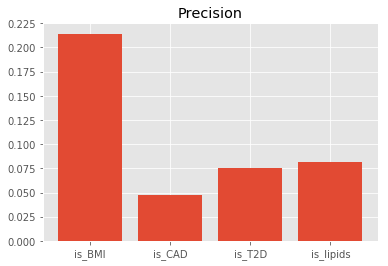

In [87]:
y = ev.multilabel_precision(y_test, predictions)
plt.bar(y_train.columns, y)
plt.title('Precision')
plt.show()

In [88]:
print("Hamming score is {0:.2f}".format(hamming_score(y_test, predictions)))
print("Hamming loss is {0:.2f}".format(hamming_loss(y_test, predictions)))

Hamming score is 0.46
Hamming loss is 0.29
